#**Forecasting product demand**

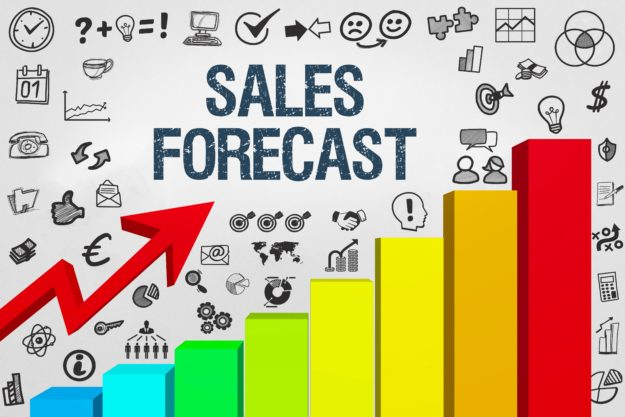

###**Objective:**

The objective of this notebook is to forecast demand of products at a retail outlet based on historical data.

---



###**About Dataset:**

The dataset consist of four columns i.e. Date, Store, Item, Sales. It consist of daily sales of various electronics products from the year 2013/01/01 to 2017/12/31 with 2,19,120 rows.

---



In [1]:
#importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import norm, skew 
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [2]:
#reading the data
df=pd.read_csv('https://raw.githubusercontent.com/parabviraj/Datasets/main/product_data.csv')
df.head()

,date,store,item,sales
0,01-01-2013,1,Clock,13
1,02-01-2013,1,Clock,11
2,03-01-2013,1,Clock,14
3,04-01-2013,1,Clock,13
4,05-01-2013,1,Clock,10


In [3]:
df.tail()

,date,store,item,sales
219115,27-12-2017,10,Projector,59
219116,28-12-2017,10,Projector,65
219117,29-12-2017,10,Projector,74
219118,30-12-2017,10,Projector,81
219119,31-12-2017,10,Projector,99


In [4]:
df.shape

(219120, 4)

Our dataset has 2,19,120 rows and 4 columns.

---



In [5]:
#datatypes
df.dtypes

date     object
store     int64
item     object
sales     int64
dtype: object

In [6]:
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Dataset does not contain null values.

---



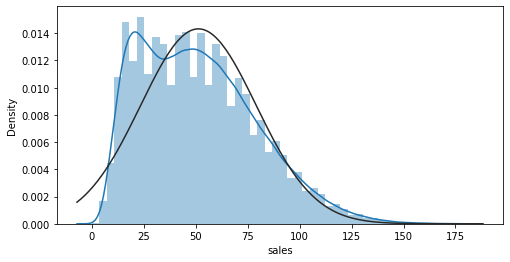

In [7]:
#check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams

rcParams['figure.figsize'] = 8,4

sns.distplot(df['sales'], fit=norm)

###**Univariate Analysis:**

In [8]:
df['item'].value_counts().sort_values(ascending = False)

Clock          18260
Ceiling Fan    18260
T.V.           18260
Iron           18260
Laptop         18260
Camera         18260
Smartwatch     18260
Drone          18260
Oven           18260
Mouse          18260
Printer        18260
Projector      18260
Name: item, dtype: int64

There are 18,260 items each.

---



In [9]:
#date wise sales
data = df[['date', 'sales']]
data.head()

,date,sales
0,01-01-2013,13
1,02-01-2013,11
2,03-01-2013,14
3,04-01-2013,13
4,05-01-2013,10


In [10]:
#item wise sales
isales=df.groupby('item').sum().sort_values('sales', ascending = False)
isales.drop(['store'], axis=1,inplace=True)
isales

,sales
item,
Drone,1405108
Mouse,1337133
Printer,1271925
Projector,1271534
Ceiling Fan,1069564
Smartwatch,1068777
Camera,1068281
Oven,938379
T.V.,669087


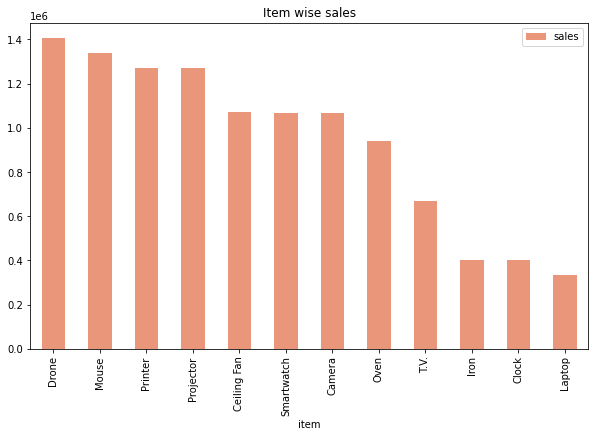

In [11]:
isales.plot(kind='bar',figsize=(10,6),title='Item wise sales',color='darksalmon')

Here we can see that Drone has the highest sales(14,05,108) whereas laptop has the lowest sales(3,35,230).

---



In [12]:
#store wise sales
stsales=df.groupby('store').sum().sort_values('sales', ascending = False)
stsales

,sales
store,
2,1441788
8,1379352
3,1280102
10,1261440
9,1183928
4,1181650
1,1018041
6,854802
5,854512


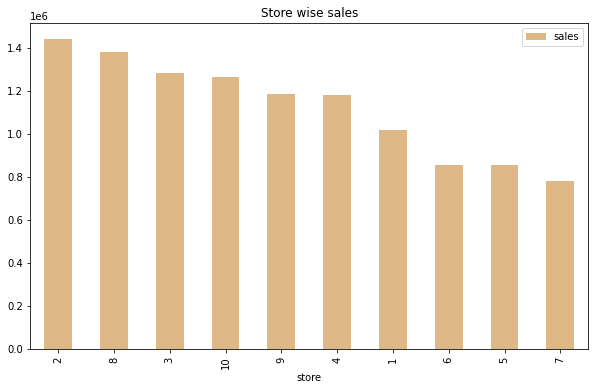

In [13]:
from seaborn.widgets import color_palette
stsales.plot(kind='bar',figsize=(10,6),title='Store wise sales',color='burlywood')

Here we can see that store 2 has the highest sales(14,41,788) wheras store 7 has the lowest sales(7,82,694).

---



In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219120 entries, 0 to 219119
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    219120 non-null  object
 1   store   219120 non-null  int64 
 2   item    219120 non-null  object
 3   sales   219120 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.7+ MB


In [15]:
df['date']=pd.to_datetime(df['date'])

In [16]:
df.set_index('date',inplace=True)

In [17]:
#resampling the data monthwise
msales=df.resample('M').sum()
msales.drop(['store'], axis=1,inplace=True)
msales.head(13)

,sales
date,
2013-01-31,126413
2013-02-28,123249
2013-03-31,151695
2013-04-30,157322
2013-05-31,169647
2013-06-30,175957
2013-07-31,186816
2013-08-31,171446
2013-09-30,158895


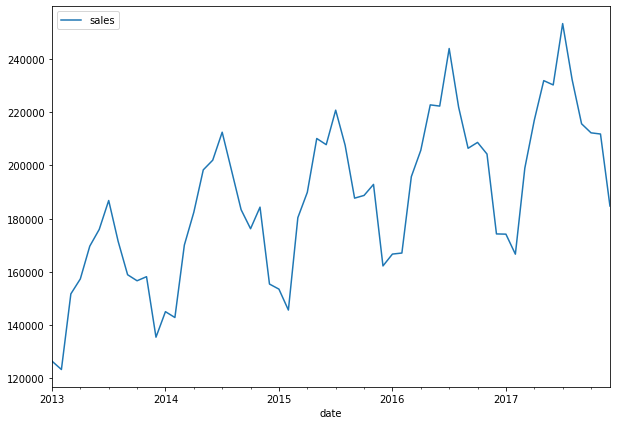

In [18]:
msales.plot(figsize=(10,7))

In this graph, we can see the sales are gradually increased over the years.


---



In [19]:
# Decompose the timeseries into 4 components
decomposition = sm.tsa.seasonal_decompose(msales, model='additive')

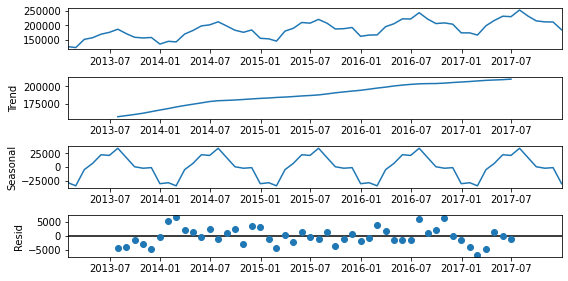

In [20]:
fig = decomposition.plot()

####**Adfuller Test**

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
def stest(s):
    r=adfuller(s)
    l=['ADF test','p-value','#lags used','no. of observations used']
    for v,la in zip(r,l):
        print(la,'->',str(v))
    print()
    if r[1]<=0.05:
        print('data is stationary')
    else:
        print('data is not stationary')

In [23]:
stest(msales['sales'])

ADF test -> -4.539877070913149
p-value -> 0.00016646639601216947
#lags used -> 11
no. of observations used -> 48

data is stationary


By applying adfuller test here we get that the data is stationary.

---



####**Autocorrelation**

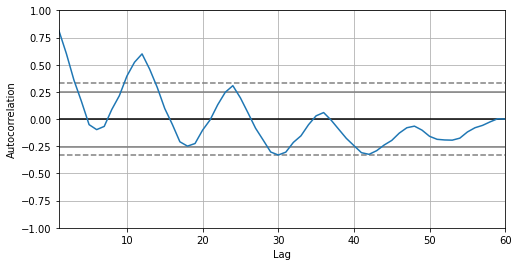

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(msales['sales'])
plt.show()

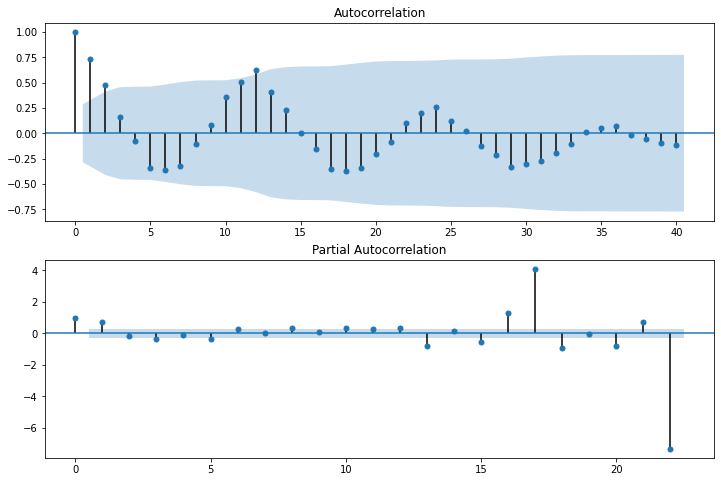

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(msales['sales'].iloc[13:],lags=40,ax=ax1)

ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(msales['sales'].iloc[13:],lags=22,ax=ax2)

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

---



# **ARIMA MODEL**

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [27]:
ts=ARIMA(msales.sales, order=(1,1,1))
model=ts.fit()

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -654.672
Method:                       css-mle   S.D. of innovations          15947.244
Date:                Mon, 14 Nov 2022   AIC                           1317.344
Time:                        06:23:17   BIC                           1325.655
Sample:                    02-28-2013   HQIC                          1320.588
                         - 12-31-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           988.5592   2496.041      0.396      0.692   -3903.592    5880.711
ar.L1.D.sales     0.4316      0.348      1.240      0.215      -0.251       1.114
ma.L1.D.sales    -0.3134      0.347     -0.904      0.366      -0.993       0.366
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3172           +0.0000j            2.3172            0.0000
MA.1            3.1912           +0.0000j            3.1912            0.0000
-----------------------------------------------------------------------------
"""

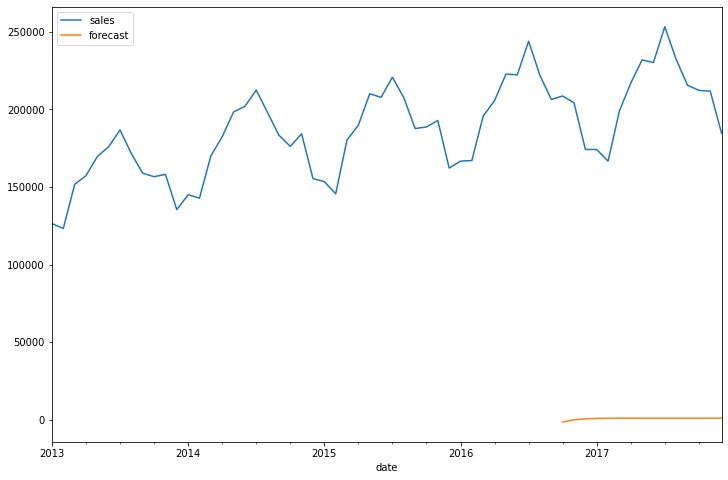

In [29]:
msales['forecast']=model.predict(start=45,end=60,dynamic=True)
msales[['sales','forecast']].plot(figsize=(12,8))

- By applying Arima model we didn't get the  expected forecasting graph.

- So we'll go for Sarimax model here.


---



#**SARIMAX MODEL**

In [30]:
ts=sm.tsa.statespace.SARIMAX(msales['sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
model2=ts.fit()

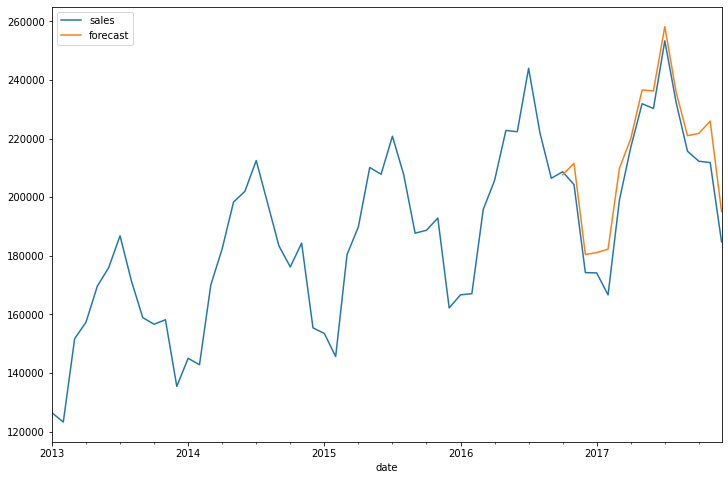

In [31]:
msales['forecast']=model2.predict(start=45,end=60,dynamic=True)
msales[['sales','forecast']].plot(figsize=(12,8))

- Here Sarimax model performed well.

- So we'll continue it for the forecasting.

---



# **FUTURE FORECASTING**

In [32]:
#Creating future dates
from pandas.tseries.offsets import DateOffset
futuredates=[msales.index[-1]+DateOffset(months=x)for x in range(0,24)]

In [33]:
futuredatedf=pd.DataFrame(index=futuredates[1:], columns=msales.columns)

In [34]:
futuredatedf.tail()

,sales,forecast
2019-07-31,NaN,NaN
2019-08-31,NaN,NaN
2019-09-30,NaN,NaN
2019-10-31,NaN,NaN
2019-11-30,NaN,NaN


In [35]:
future=pd.concat([msales,futuredatedf])

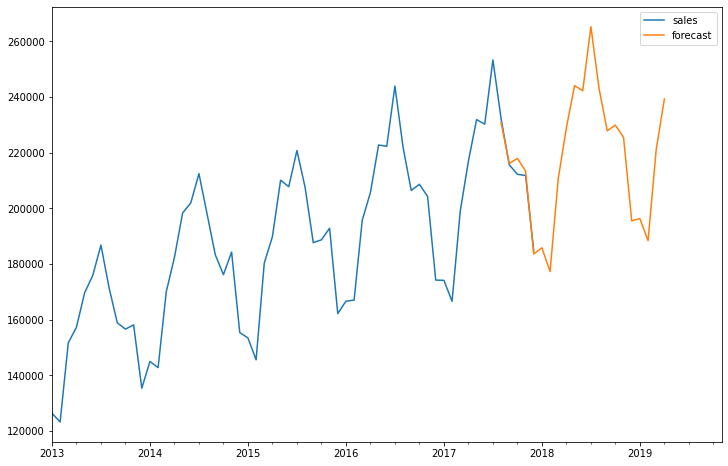

In [36]:
future['forecast']=model2.predict(start=55,end=75,dynamic=True)
future[['sales','forecast']].plot(figsize=(12,8))

###**Conclusion:**

- Here we get the future forecasting of sales using Sarimax model.
- By having insight into not only current data but projections of what could happen in the future, businesses can make better adjustments. 
- Forecasts help businesses optimise their strategies and alter their current operations to change potential outcomes.

---

